In [ ]:
upstream = ['01-uniform-files']
product = None
reference_sequence = None
residues = None
alignment_files = None
chain_map = None

In [ ]:

# reference_sequence = 'Nif_Azotobacter_vinelandii'
# residues = [
#     "D:V:70",
#     "D:Q:191",
#     "D:H:195",
#     "D:Y:229",
#     "D:I:231",
#     "D:C:275",
#     "D:R:277",
#     "D:S:278",
#     "D:I:355",
#     "D:G:356",
#     "D:G:357",
#     "D:L:358",
#     "D:R:359",
#     "D:P:360",
#     "D:E:380",
#     "D:F:381",
#     "D:M:441",
#     "D:H:442",
# ]

# alignment_files = {
#     "D": "../sequences/AGNifAlign105.ext-anc.alt.D.fasta",
#     "K": "../sequences/AGNifAlign105.ext-anc.alt.K.fasta",
#     "H": "../sequences/AGNifAlign105.ext-anc.alt.H.fasta"
# }

# 06 - Active site analysis

In [1]:
from Bio import AlignIO, SeqIO, Seq
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import entropy
import prody as pdy

In [64]:
def process_alignment(file):
    alignment = AlignIO.read(open(file), format='fasta')
    sequences = [dict(id=x.id, seq=str(x.seq)) for x in alignment]
    sequences = pd.DataFrame.from_records(sequences)
    return sequences

In [71]:


sequences = dict(
    (
        k, process_alignment(f)
    ) for k, f in alignment_files.items()
)
sequences.keys()

dict_keys(['D', 'K', 'H'])

In [72]:
def alignment_position(sequence, sequence_position, residue):
    k = 0
    for i, c in enumerate(sequence):
        if c != '-':
            k += 1
            if k == sequence_position:
                if c == residue:
                    return i
                else:
                    raise RuntimeError(f"residue did not match, {residue} {c}")
    raise RuntimeError("coult not find it")

In [73]:

reference_seqs = dict(
    (k, sequences[k].query(f'id == "{reference_sequence}"').seq.values[0]) for k in sequences.keys()
)

g = []
for (chain, residue, position) in map(lambda x: x.split(':'), residues):
    p = alignment_position(
        reference_seqs[chain], 
        int(position),
        residue
    )
    g.append(dict(ref_position=position, ref_residue=residue, aln_position=p, chain=chain))
active_site = pd.DataFrame.from_records(g)
active_site

,ref_position,ref_residue,aln_position,chain
0,70,V,205,D
1,191,Q,365,D
2,195,H,369,D
3,229,Y,502,D
4,231,I,505,D
5,275,C,552,D
6,277,R,554,D
7,278,S,555,D
8,355,I,635,D
9,356,G,636,D


In [74]:
def contains_gaps(chain, position, sequences):
    position = int(position)
    X = np.stack(list(map(lambda x: list(x), sequences[chain].seq.values)))
    return np.any(X[:, position] == '-')

def position_residues(chain, position, sequences):
    position = int(position)
    X = np.stack(list(map(lambda x: list(x), sequences[chain].seq.values)))
    row = X[:, position]
    return ''.join(np.unique(row).tolist())

def position_entropy(chain, position, sequences):
    position = int(position)
    X = np.stack(list(map(lambda x: list(x), sequences[chain].seq.values)))
    row = X[:, position]
    return entropy([ np.sum(row == c) for c in 'ACDEFGHIKLMNPQRSTVWY'])

In [78]:
active_site['is_gapped'] = active_site.apply(lambda x: contains_gaps(x.chain, x.aln_position, sequences), axis=1)
active_site['entropy'] = active_site.apply(lambda x: position_entropy(x.chain, x.aln_position, sequences), axis=1)
active_site['possible_residues'] = active_site.apply(lambda x: position_residues(x.chain, x.aln_position, sequences), axis=1)

In [79]:
active_site

,ref_position,ref_residue,aln_position,chain,is_gapped,entropy,possible_residues
0,70,V,205,D,False,0.000000,V
1,191,Q,365,D,False,0.000000,Q
2,195,H,369,D,False,0.000000,H
3,229,Y,502,D,False,0.075797,FY
4,231,I,505,D,False,0.120666,IM
5,275,C,552,D,False,0.000000,C
6,277,R,554,D,False,0.000000,R
7,278,S,555,D,False,0.000000,S
8,355,I,635,D,False,0.719835,ACILMPQSTV
9,356,G,636,D,False,0.000000,G


In [80]:
reference = pd.read_csv('reference.csv')
reference['original_name'] = reference['original_name'].apply(lambda x: x.replace('_001.rechained.pdb', '').replace('Anc_', ''))
reference

,original_name,id,stochiometry,average_pLDDT,taxond_id,lineage,scientific_name,is_ancestral,nitrogenase_type,status,chain_reference,variant,clade
0,Nif_Alkaliflexus_imshenetskii,nsdb-000001,DDKK,94.650435,286730,Bacteria; Bacteroidota; Bacteroidia; Marinilab...,Alkaliflexus imshenetskii,False,Nif,gold,"{'A': 'D', 'B': 'K', 'D': 'D', 'E': 'K'}",WT,nif-ii
1,Nif_Desulfohalovibrio_alkalitolerans,nsdb-000002,DDKK,94.695321,NaN,NaN,Desulfohalovibrio alkalitolerans,False,Nif,gold,"{'A': 'D', 'B': 'K', 'D': 'D', 'E': 'K'}",WT,nif-ii
2,Nif_Candidatus_Methanolliviera_sp_GoM_asphalt,nsdb-000003,DDKK,94.605453,NaN,NaN,Candidatus Methanolliviera sp GoM asphalt,False,Nif,gold,"{'A': 'D', 'B': 'K', 'D': 'D', 'E': 'K'}",WT,nif-iii
3,Nif_Marinilabilia_sp_WTE,nsdb-000004,DDKK,94.377139,NaN,NaN,Marinilabilia sp WTE,False,Nif,gold,"{'A': 'D', 'B': 'K', 'D': 'D', 'E': 'K'}",WT,nif-ii
4,Nif_Cupriavidus_sp_amp6,nsdb-000005,DDKK,94.706025,NaN,NaN,Cupriavidus sp amp6,False,Nif,gold,"{'A': 'D', 'B': 'K', 'D': 'D', 'E': 'K'}",WT,nif-i
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5363,779_alt3,nsdb-005364,HH,90.007800,Anc_779_alt3,Anc_779_alt3,Anc_779_alt3,True,Anc,silver,"{'A': 'H', 'B': 'H'}",ALT3,other
5364,1538_alt3,nsdb-005365,HH,90.627836,Anc_1538_alt3,Anc_1538_alt3,Anc_1538_alt3,True,Anc,silver,"{'A': 'H', 'B': 'H'}",ALT3,other
5365,1486_alt4,nsdb-005366,HH,87.068425,Anc_1486_alt4,Anc_1486_alt4,Anc_1486_alt4,True,Anc,silver,"{'A': 'H', 'B': 'H'}",ALT4,other
5366,1464_alt2,nsdb-005367,HH,87.755495,Anc_1464_alt2,Anc_1464_alt2,Anc_1464_alt2,True,Anc,silver,"{'A': 'H', 'B': 'H'}",ALT2,other


In [84]:
# reference = pd.merge(reference, D_sequences, left_on=['original_name'], right_on=['id'], how='inner')
reference = reference.query('stochiometry == "DDKK" and status == "gold"').copy()
reference['file'] = reference['id'].apply(lambda x: f'pdb/{x}.pdb')
#reference = reference

In [85]:
def map_sequence_position(sequence, alignment_position):
    k = 0
    for i, c in enumerate(sequence):
        if i == alignment_position:
            return len(sequence[:i].replace('-', '')) + 1

In [96]:
def get_active_site_coordinates(x, sequences, chains, positions, chain_map):
    pdb = pdy.parsePDB(x.file)
    active_site_A = []
    active_site_C = []
    for c, p in zip(chains, positions):
        sequence = sequences[c].set_index('id').loc[x.original_name].values[0]
        r = map_sequence_position(sequence, p)
        A, D = chain_map[c]
        residue_A = pdb.select(f'resnum == {r} and chain {A} and name CA').getCoords()[0, :]
        residue_C = pdb.select(f'resnum == {r} and chain {D} and name CA').getCoords()[0, :]
        active_site_A.append(residue_A)
        active_site_C.append(residue_C)
    active_site_A = np.stack(active_site_A)
    active_site_C = np.stack(active_site_C)
    return dict(file=x.file, active_site_A=active_site_A, active_site_C=active_site_C)

In [97]:
g = reference.apply(
    lambda x: get_active_site_coordinates(
        x, 
        sequences, 
        active_site.chain.tolist(), 
        active_site.aln_position.tolist(),
        chain_map
    ), axis=1
)
g = pd.DataFrame.from_records(g)

In [98]:
rmsds = []
for k1, row1 in g.iterrows():
    for k2, row2 in g.iterrows():

        if k1 == k2: continue

        mob_AA = pdy.superpose(row1.active_site_A, row2.active_site_A)[0]
        mob_AC = pdy.superpose(row1.active_site_A, row2.active_site_C)[0]
        mob_CA = pdy.superpose(row1.active_site_C, row2.active_site_A)[0]
        mob_CC = pdy.superpose(row1.active_site_C, row2.active_site_C)[0]

        rmsds.append(
            dict(
                id1=row1.file,
                id2=row2.file,
                rmsd_AA=pdy.calcRMSD(mob_AA, row2.active_site_A),
                rmsd_AC=pdy.calcRMSD(mob_AC, row2.active_site_C),
                rmsd_CA=pdy.calcRMSD(mob_CA, row2.active_site_A),
                rmsd_CC=pdy.calcRMSD(mob_CC, row2.active_site_C),
            )
        )
        
rmsds = pd.DataFrame.from_records(rmsds)
rmsds = rmsds.melt(
    id_vars=['id1', 'id2'], 
    value_vars=['rmsd_AA', 'rmsd_AC', 'rmsd_CA', 'rmsd_CC']
)

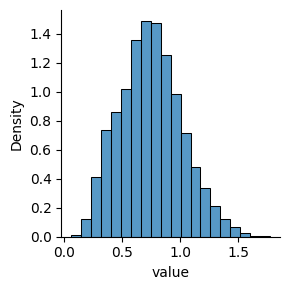

In [99]:
sns.displot(data=rmsds, x='value', bins=20, height=3, stat='density')

In [100]:
rmsds.describe().round(2)

,value
count,2362368.00
mean,0.75
std,0.27
min,0.06
25%,0.56
50%,0.74
75%,0.92
max,1.77


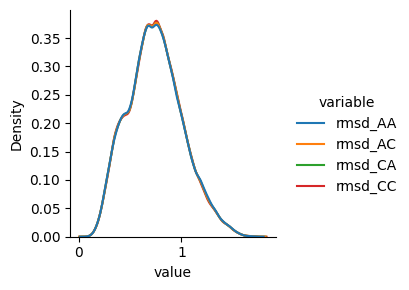

In [101]:
sns.displot(data=rmsds, x='value', kind='kde', hue='variable', height=3)

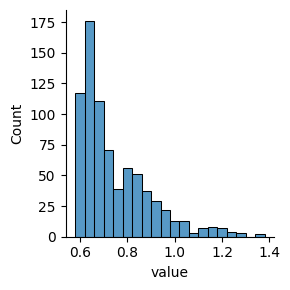

In [102]:
rmsds_g = rmsds[['id1', 'value']].groupby('id1').mean()
sns.displot(data=rmsds_g, x='value', height=3)

In [103]:
rmsds_g.describe()

,value
count,769.000000
mean,0.746838
std,0.147397
min,0.580628
25%,0.636666
50%,0.691435
75%,0.826723
max,1.380656


In [ ]:
rmsds.to_json(product['data'])
rmsds_g.to_json(product['data-grouped'])